In [1]:
# import packages
import pandas as pd
import functions
from tqdm import tqdm
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import DBSCAN

### Group 12:

Paolo Zilviano (zilviano.1916518@studenti.uniroma1.it)

Ana Carina Branescu (ana.branescu03@gmail.com)

Domenico Mangieri (mangieri.1883920@studenti.uniroma1.it)

Milad Torabi (miladtorabi65@gmail.com)

# Homework 4 - Recommendation systems and clustering everywhere

<H1>1. Recommendation sytem</H1>

The task is to implement our version of the LSH algorithm, which will take as input the user's preferred genre of movies, find the most similar users to this user, and recommend the most watched movies by those who are more similar to the user.

Looking at the data, we can see that there is data available for each user for the movies the user clicked on. Our first goal is to gather the title and genre of the maximum top 10 movies that each user clicked on regarding the number of clicks.

In [2]:
df = pd.read_csv("vodclickstream_uk_movies_03.csv", delimiter=',')
df.dtypes

Unnamed: 0        int64
datetime         object
duration        float64
title            object
genres           object
release_date     object
movie_id         object
user_id          object
dtype: object

In [3]:
df

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id
0,58773,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe
1,58774,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510
2,58775,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf
3,58776,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6
4,58777,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, ...",2004-11-19,a80d6fc2aa,a57c992287
...,...,...,...,...,...,...,...,...
671731,730504,2019-06-30 21:37:08,851.0,Oprah Presents When They See Us Now,Talk-Show,2019-06-12,43cd23f30f,57501964fd
671732,730505,2019-06-30 21:49:34,91157.0,HALO Legends,"Animation, Action, Adventure, Family, Sci-Fi",2010-02-16,febf42d55f,d4fcb079ba
671733,730506,2019-06-30 22:00:44,0.0,Pacific Rim,"Action, Adventure, Sci-Fi",2013-07-12,7b15e5ada1,4a14a2cd5a
671734,730507,2019-06-30 22:04:23,0.0,ReMastered: The Two Killings of Sam Cooke,"Documentary, Music",2019-02-08,52d49c515a,0b8163ea4b


In [4]:
# We want to gather the title and genre of the top 10 movies that each user clicked on regarding the number of clicks.
user_movies_genres, df_top10 = functions.user_gather(df)
user_movies_genres

{'00004e2862': [{'Hannibal'}, {'Crime', 'Drama', 'Thriller'}],
 '000052a0a0': [{'Ant-Man',
   'Drive Angry',
   'Frailty',
   'Green Room',
   'Jumanji',
   'Looper',
   'Resident Evil',
   'Resident Evil: Retribution',
   'The Nice Guys',
   'The SpongeBob Movie: Sponge Out of Water'},
  {'Action',
   'Adventure',
   'Animation',
   'Comedy',
   'Crime',
   'Drama',
   'Family',
   'Fantasy',
   'Horror',
   'Music',
   'Mystery',
   'Sci-Fi',
   'Thriller'}],
 '000090e7c8': [{'Mute'}, {'Mystery', 'Sci-Fi', 'Thriller'}],
 '000118a755': [{'From Dusk till Dawn (franchise)', 'The Omen'}, {'Horror'}],
 '000296842d': [{'Black Mirror: Bandersnatch'},
  {'Drama', 'Mystery', 'Sci-Fi', 'Thriller'}],
 '0002aab109': [{'127 Hours', 'King Cobra', 'The Iron Lady'},
  {'Biography', 'Comedy', 'Crime', 'Drama'}],
 '0002abf14f': [{'Fifty Shades Darker'}, {'Drama', 'Romance'}],
 '0002d1c4b1': [{'Hot Bot'}, {'Comedy', 'Sci-Fi'}],
 '000499c2b6': [{'Flushed Away'},
  {'Adventure', 'Animation', 'Comedy', 'F

<H2>1.2 Minhash Signatures</H2>

Using the movie's genre and user_ids, we'll implement our min-hash signatures and LSH so that users with similar interests will appear in the same bucet.

In [5]:
# Firs of all we need the set of all the genres present in the dataset
genres_set = functions.genres_set(df)
genres_set

{'Action',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Film-Noir',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'News',
 'Reality-TV',
 'Romance',
 'Sci-Fi',
 'Short',
 'Sport',
 'Talk-Show',
 'Thriller',
 'War',
 'Western'}

In [6]:
# Creating a matrix representation of sets associating each column with a user_id and each row with a genre.
# Each column value has to be 1 if user watched that genre and 0 otherwise.
matrix_sets, user_ids_list = functions.generate_sets_matrix(genres_set, user_movies_genres)

print(matrix_sets)
print(matrix_sets.shape)

[[0. 1. 0. ... 1. 1. 0.]
 [0. 1. 0. ... 0. 1. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
(26, 161918)


----------------------------------------------------------------------------------------------------------------------------
To minhash a set represented by a column of the characteristic matrix, pick a permutation of the rows. The minhash value of any column is the number of the first row, in the permuted order, in which the column has a 1. 
There is a remarkable connection between minhashing and Jaccard similarity of the sets that are minhashed. The probability that the minhash function for a random permutation of rows produces the same value for two sets equals the Jaccard similarity of those sets.


It is not feasible to permute a large characteristic matrix explicitly. Even picking a random permutation of millions or billions of rows is time-consuming, and the necessary sorting of the rows would take even more time. Fortunately, it is possible to simulate the effect of a random permutation by a random hash function that maps row numbers to as many buckets as there are rows. A hash function that maps integers 0, 1, . . . , k − 1 to bucket.

Thus, instead of picking n random permutations of rows, we pick n randomly chosen hash functions h1, h2, . . . , hn on the rows. We construct the signatur matrix by considering each row in their given order. Let SIG(i, c) be the element of the signature matrix for the ith hash function and column c. Initially, et SIG(i, c) to ∞ for all i and c.

We handle row r by doing the follow:

1) Compute h1(r), h2(r), . . . , hn(r).

2) For each column c do the following:
        
            If c has 0 in row r do nothing

In [7]:
sign_matrix = functions.generate_sign_matrix(matrix_sets)
print(sign_matrix)

[[ 7  7  7 ...  7  7  7]
 [20  8 11 ...  8  8 29]
 [ 1  1  4 ...  1 11  1]
 ...
 [ 4  2 15 ...  0  0  4]
 [ 0  0  5 ...  0  5  0]
 [ 3  0  0 ... 13  3 18]]


The signature matrix created above will now be divided into n bands of r rows each, and each band will be hashed separately

In [8]:
# For this example, we are setting b = 6 band, which means that we will consider any titles with the same first fifteen rows to be similar. 
# So we'll have b = 6 and r = 15. At the end we'll have 6 buckets containing each n sets filled with similar users.
r = 15
buckets = functions.generate_buckets(r, sign_matrix)

print(len(buckets))
print(len(buckets[0]))

6
12682


In [9]:
# Now we create a list of dictionary (one for each band) with the user_id as key and as value a set cointaining all the other similar users
# We'll need this list of vocabulary to find the most similar user.
user_list = functions.generate_vocabulary(buckets, user_ids_list)

<H2>1.3 Locality-Sensitive Hashing (LSH)</H2>

Now that the buckets are ready, it's time to ask a few queries. Given some user ids we have to recommend at most five movies to the user to watch based on the movies clicked by similar users.

To recommend at most five movies given a user_id, use the following procedure:

1) Identify the two most similar users to this user
2) If these two users have any movies in common, recommend those movies based on the total number of clicks by there users.
3) If there are no more common movies, try to propose the most clicked movies by the most similar user first, followed by the other user.

At the emd of the process, we expect to see at most five movies recommended to the user.

In [10]:
# Here the user can insert a user_id
query = input('Pleas insert a user-id in input: ')
while query not in user_ids_list:
    print(query + ' is not a user_id present in the database')
    query = input('Search \U0001F50D Now: ')

# Gievn an user_id first of all we need to find all the similar users.
final_user_list = functions.find_similar_users(user_list, user_ids_list, query)
print(final_user_list)

# Then we find the ordered 5 recommended movies for the given user
rec_5_movies = functions.recommended_movies(user_movies_genres, df_top10, final_user_list)
for el in rec_5_movies:
    print(el)

Pleas insert a user-id in input:  544dcbc510


['8e43f46dfd', '6f647e8856']
Berlin Syndrome
Harold & Kumar Go to White Castle
Stranger than Fiction
The Beach
The Cable Guy


## 2.1.

## 1. Let's read the dataset

In [ ]:
#netflix_df = pd.read_csv('C:/Users/utente/Desktop/DATA SCIENCE/ADM/HW4/vodclickstream_uk_movies_03.csv')
netflix_df = pd.read_csv('C:/Users/anaca/Downloads/adm4/vodclickstream_uk_movies_03.csv')
netflix_df

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id
0,58773,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe
1,58774,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510
2,58775,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf
3,58776,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6
4,58777,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, ...",2004-11-19,a80d6fc2aa,a57c992287
...,...,...,...,...,...,...,...,...
671731,730504,2019-06-30 21:37:08,851.0,Oprah Presents When They See Us Now,Talk-Show,2019-06-12,43cd23f30f,57501964fd
671732,730505,2019-06-30 21:49:34,91157.0,HALO Legends,"Animation, Action, Adventure, Family, Sci-Fi",2010-02-16,febf42d55f,d4fcb079ba
671733,730506,2019-06-30 22:00:44,0.0,Pacific Rim,"Action, Adventure, Sci-Fi",2013-07-12,7b15e5ada1,4a14a2cd5a
671734,730507,2019-06-30 22:04:23,0.0,ReMastered: The Two Killings of Sam Cooke,"Documentary, Music",2019-02-08,52d49c515a,0b8163ea4b


...We have to preprocess a few variables...

In [ ]:
# datetime was originally provided as a string, 
# now we convert it in a proper datetime type variable
netflix_df['datetime'] = pd.to_datetime(netflix_df['datetime'])

# in the dataset were also present values equal to -1 that indicated
# absence of data in the column 'duration', we replace them with 'nan' values
netflix_df['duration'] = netflix_df['duration'].replace(-1.0, np.nan)
netflix_df

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id
0,58773,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe
1,58774,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510
2,58775,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf
3,58776,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6
4,58777,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, ...",2004-11-19,a80d6fc2aa,a57c992287
...,...,...,...,...,...,...,...,...
671731,730504,2019-06-30 21:37:08,851.0,Oprah Presents When They See Us Now,Talk-Show,2019-06-12,43cd23f30f,57501964fd
671732,730505,2019-06-30 21:49:34,91157.0,HALO Legends,"Animation, Action, Adventure, Family, Sci-Fi",2010-02-16,febf42d55f,d4fcb079ba
671733,730506,2019-06-30 22:00:44,0.0,Pacific Rim,"Action, Adventure, Sci-Fi",2013-07-12,7b15e5ada1,4a14a2cd5a
671734,730507,2019-06-30 22:04:23,0.0,ReMastered: The Two Killings of Sam Cooke,"Documentary, Music",2019-02-08,52d49c515a,0b8163ea4b


While exploring the dataset we noticed that there where duplicate clicks, in the sense that there was more than one click with the same 'user_id', 'movie_id' and 'datetime'. This is maybe due tue people who have no patience click many time on a title, so a lot of useless data is recorded. 

What we did was grouping the date buy the number of cases in which a click with the same values appears more then once creating the variable 'click_count' and summing the total duration.

In [ ]:
df = netflix_df.groupby(['user_id', 'movie_id', 'datetime']).agg(
    click_count = ('datetime', 'size'),
    #datetime = ('datetime', 'first'),
    duration = ('duration', 'sum'),
    title = ('title', 'first'), 
    genres = ('genres', 'first'),
    release_date = ('release_date', 'first')).reset_index()
df

,user_id,movie_id,datetime,click_count,duration,title,genres,release_date
0,00004e2862,9bfee795ff,2017-12-05 20:39:15,1,0.0,Hannibal,"Crime, Drama, Thriller",2001-02-09
1,000052a0a0,43bb6de314,2017-05-30 20:36:34,1,0.0,Green Room,"Horror, Music, Thriller",2016-05-13
2,000052a0a0,4718f9963c,2017-06-18 20:38:02,1,0.0,Looper,"Action, Drama, Sci-Fi, Thriller",2012-09-28
3,000052a0a0,4718f9963c,2017-06-18 20:44:27,7,600.0,Looper,"Action, Drama, Sci-Fi, Thriller",2012-09-28
4,000052a0a0,4718f9963c,2017-06-18 20:54:27,1,6736.0,Looper,"Action, Drama, Sci-Fi, Thriller",2012-09-28
...,...,...,...,...,...,...,...,...
645225,fffeac83be,cb6d7afd76,2017-08-11 21:03:15,1,2171.0,Amanda Knox,"Documentary, Crime",2016-09-30
645226,fffeac83be,dda0eae17b,2017-08-10 07:15:41,1,49440.0,Enemy at the Gates,"Drama, History, War",2001-03-16
645227,ffff2c5f9e,6467fee6b6,2017-07-23 15:02:43,1,0.0,Hot Fuzz,"Action, Comedy, Mystery, Thriller",2007-04-20
645228,ffff2c5f9e,9ab62a3f2c,2017-07-23 14:45:12,1,0.0,Forks Over Knives,Documentary,2013-10-16


Initializing the users-oriented dataframe in order to do the tasks required in hw pt2

In [ ]:
users = pd.DataFrame()
users['user_id'] = df['user_id'].unique()
users

,user_id
0,00004e2862
1,000052a0a0
2,000090e7c8
3,000118a755
4,000296842d
...,...
161913,fffd9bf758
161914,fffe7b777b
161915,fffeac83be
161916,ffff2c5f9e


## 2. Create new features for each user - Feature Engineering

### 1) Favourite genre column

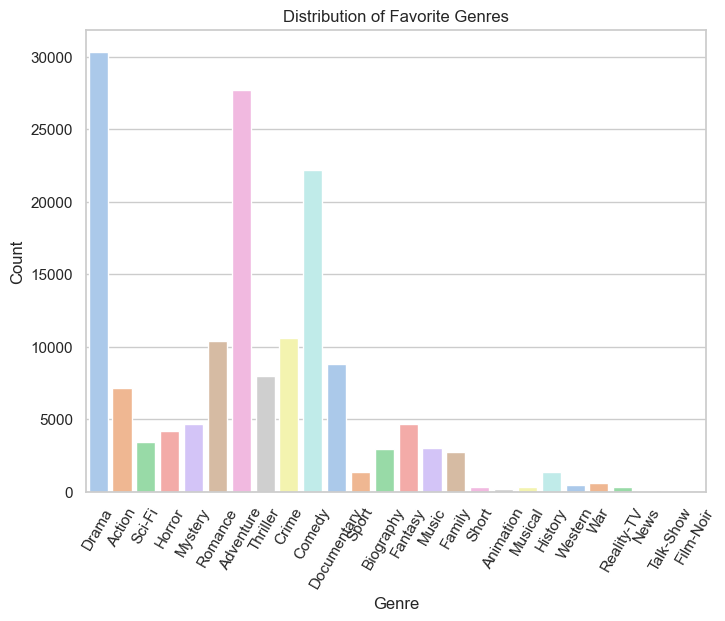

In [ ]:
# We create a list that contains all the genre under which a single title is classified
df['genre_list'] = df['genres'].str.split(',')

grouped_duration = df.explode('genre_list').groupby(['user_id', 'genre_list'])['duration'].sum().reset_index(name='total_duration')

# Creating a dictionary for every user with the summed duration for each genre 
user_genre_dict = grouped_duration.groupby('user_id').apply(lambda x: dict(zip(x['genre_list'], x['total_duration']))).reset_index(name='genre_duration_dict')

users = users.merge(user_genre_dict[['user_id', 'genre_duration_dict']], on='user_id', how='left')

# There is a 'NOT AVAILABLE' category for the genres, that we changed to NaN values for each user if
# the user's favourite category results 'NOT AVAILBLE'
users['fav_genre'] = users['genre_duration_dict'].apply(lambda x: max(x, key=x.get) if x else np.nan)
users['fav_genre'] = users['fav_genre'].replace('NOT AVAILABLE', np.nan)

# During the exploration of the dataset we noticed that there are some duplicates
# that python doesn't automatically recognize because the string has some spaces.
# In order to have everything clean we strip the values so we will have the 
# correct amount of categories. 
users['fav_genre'] = users['fav_genre'].apply(lambda x: x.strip() if type(x) == str else x)

# Now we can drop the col 'genre_duration_dict'
users = users.drop(columns = 'genre_duration_dict')

# A plot produced to sum up the favourite genres around the users
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")
sns.countplot(x='fav_genre', data=users, palette='pastel')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.title('Distribution of Favorite Genres')
plt.xticks(rotation=60)
plt.show()

### 2)  Calculating average duration for each user

In [ ]:
# After we initialize the column we simply need a groupby to create the 'duration'
# column in the users dataset, specifing we want the mean of the durations
# for each user

users['duration'] = [0.0] * users.shape[0]
users['duration'] = users['user_id'].map(df[df['duration'] >= 0].groupby('user_id')['duration'].mean()).astype(float)

### 3)  Time of the day when the user spends the most time on the platform

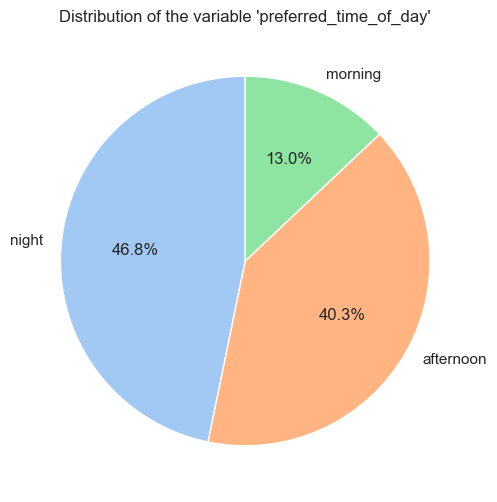

In [ ]:
# Creating a variable 'hour' to see what time of the day each click has been done

df['hour'] = df['datetime'].dt.hour
df['hour'] = df['hour'].replace(24, 0)
tod_dict = {'morning': [6,7,8,9,10,11,12], 'afternoon': [13,14,15,16,17,18,19], 'night': [20,21,22,23,0,1,2,3,4,5]}
df['time_of_day'] = df['hour'].apply(lambda x: next((tod for tod, range_ in tod_dict.items() if x in range_)))

# Creating a dictionary for every user with the summed duration for each time of the day 
grouped_duration = df.groupby(['user_id', 'time_of_day'])['duration'].sum().reset_index(name='total_duration')

user_dict = grouped_duration.groupby('user_id').apply(lambda x: dict(zip(x['time_of_day'], x['total_duration']))).reset_index(name='time_of_day_duration')

# We directly put the column 'time_of_day_duration' in the users dataset
users['time_of_day_duration'] = users['user_id'].map(user_dict.set_index('user_id')['time_of_day_duration']).fillna({})

# Generating the column with the preferred t.o.d. of each user 
users['preferred_time_of_day'] = [np.nan] * users.shape[0] 
users['preferred_time_of_day'] = users['time_of_day_duration'].apply(lambda x: max(x, key=x.get) if x else np.nan)

#now we can drop the col 'time_of_day_duration'
users = users.drop(columns = 'time_of_day_duration')

# Pieplot for this new feature
plt.figure(figsize=(6, 6))
plt.pie(users['preferred_time_of_day'].value_counts(), labels=users['preferred_time_of_day'].value_counts().index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("pastel"))
plt.title('Distribution of the variable \'preferred_time_of_day\'')
plt.show()

### 4)  Is the user an old movie lover, or are they into more recent stuff?
(recent stuff = content released after 2010)


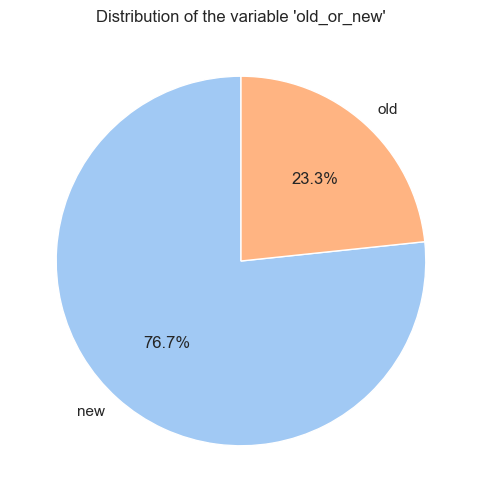

In [ ]:
# Now we do the same thing we did with the hours in the previous point, but with
# the year of the variable 'release_date'

df['release_date'] = pd.to_datetime(df['release_date'], format="%Y-%m-%d", errors = 'coerce')
df['release_year'] = df['release_date'].dt.year

# Creating a binary category >2010 or <=2010
df['release_category'] = df['release_year'].apply(lambda year: 'old' if year <= 2010 else 'new')

# Regrouping the DataFrame df by 'user_id', 'release_category' and sum the 'duration'
grouped_duration = df.groupby(['user_id', 'release_category'])['duration'].sum().reset_index(name='total_duration')

# Creates for each user a dictionary with the summed durations considering both title produced before 2010 
# and titles produced after 2010
user_dict = grouped_duration.groupby('user_id').apply(lambda x: dict(zip(x['release_category'], x['total_duration']))).reset_index(name='category_duration_dict')
users = users.merge(user_dict[['user_id', 'category_duration_dict']], on='user_id', how='left')

users['old_or_new'] = users['category_duration_dict'].apply(lambda x: max(x, key=x.get) if x else np.nan)

# drop the col 'category_duration_dict'
users = users.drop(columns = 'category_duration_dict')

# Pieplot for this new variable..
plt.figure(figsize=(6, 6))
plt.pie(users['old_or_new'].value_counts(), labels=users['old_or_new'].value_counts().index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("pastel"))
plt.title('Distribution of the variable \'old_or_new\'')
plt.show()  # we can see that there is a significant majority 
# of users who prefer the newest products rather
# than the dated titles (released before 2010)

### 5) Average time spent a day by the user

In [ ]:
# Apply the function to create a new column
df['adjusted_duration'] = df.apply(calculate_time_until_midnight, axis=1)

average_durations = df.groupby('user_id')['adjusted_duration'].mean().reset_index()

# Merge the average durations into the user DataFrame
users = pd.merge(users, average_durations, on='user_id', how='left')

# Rename the new column to 'averagetime'
users.rename(columns={'adjusted_duration': 'averagetime'}, inplace=True)

average_durations

,user_id,adjusted_duration
0,00004e2862,0.000000
1,000052a0a0,2698.888889
2,000090e7c8,0.000000
3,000118a755,0.000000
4,000296842d,14250.600000
...,...,...
161913,fffd9bf758,8495.000000
161914,fffe7b777b,1785.000000
161915,fffeac83be,9390.090909
161916,ffff2c5f9e,0.000000


## 3. Consider at least 10 additional features that can be generated for each user_id 

1. Total Watch Time
2. Number of Movies Watched 
3. Number of Genres Watched
4. Average Monthly Movies Watched
5. Year with the most movies watched
6. Watching Duration User Type
7. Seasonal Movie Preferences
8. Time since last movie watched
9. Favorite watch day of the week
10. Longest click duration

### (1) Total Watch Time

In [ ]:
# Grouping by user_id and sum the duration
total_watch_time = df.groupby('user_id')['duration'].sum().reset_index(name='total_watch_time')

#  Merging the total watch time column with the final users DataFrame
users = pd.merge(users, total_watch_time, on='user_id', how='left')

total_watch_time

,user_id,total_watch_time
0,00004e2862,0.0
1,000052a0a0,48580.0
2,000090e7c8,0.0
3,000118a755,0.0
4,000296842d,77308.0
...,...,...
161913,fffd9bf758,8495.0
161914,fffe7b777b,1785.0
161915,fffeac83be,446669.0
161916,ffff2c5f9e,0.0


### (2) Number of Movies Watched

In [ ]:
# Group by user_id and count the number of unique movies each user watched
total_movies_watched = df.groupby('user_id')['movie_id'].nunique().reset_index(name='total_movies_watched')

# Merge the number of unique movies column with the users DataFrame
users = pd.merge(users, total_movies_watched, on='user_id', how='left')

total_movies_watched

,user_id,total_movies_watched
0,00004e2862,1
1,000052a0a0,11
2,000090e7c8,1
3,000118a755,2
4,000296842d,1
...,...,...
161913,fffd9bf758,1
161914,fffe7b777b,1
161915,fffeac83be,10
161916,ffff2c5f9e,2


### (3) Number of Genres Watched

In [ ]:
# Created a copy of the 'genre_list' column from the df DataFrame 
# and replaced the 'NOT AVAILABLE' entries with NaN
df['cleaned_genre_list'] = df['genre_list'].apply(lambda x: [genre.strip() if genre != 'NOT AVAILABLE' else np.nan for genre in x])

# Explode the cleaned_genre_list column to get the genres into individual rows
df_exploded = df.explode('cleaned_genre_list')

# Group by user_id and count the unique genres
total_genres_watched = df_exploded.groupby('user_id')['cleaned_genre_list'].nunique().reset_index(name='total_genres_watched')

# Merge the total number of genres with the users DataFrame
users = pd.merge(users, total_genres_watched, on='user_id', how='left')

# Drop the temporary copy column cleaned_genre_list
df.drop(columns=['cleaned_genre_list'], inplace=True)

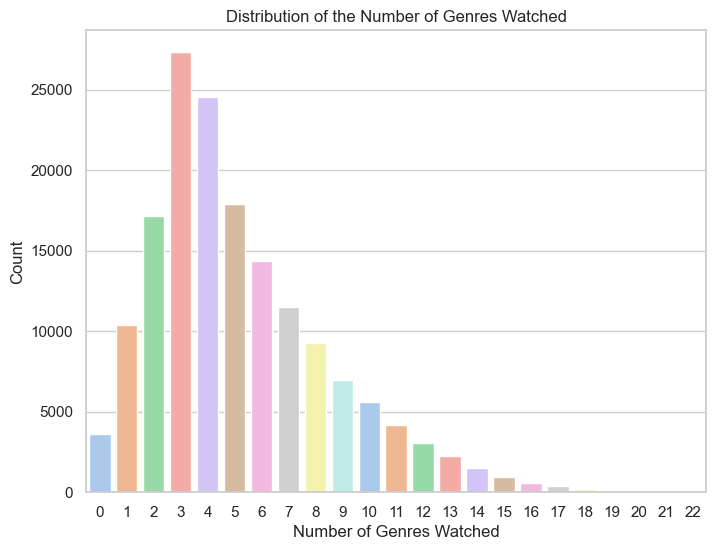

In [ ]:
# Plotting to visualize the Distribution of Genres Watched
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")
sns.countplot(x='total_genres_watched', data=users, palette='pastel')
plt.xlabel('Number of Genres Watched')
plt.ylabel('Count')
plt.title('Distribution of the Number of Genres Watched')
plt.show()

### (4) Average Monthly Movies Watched

In [ ]:
# Getting the year and month from the 'datetime' column in the df DataFrame
# as we have multiple years recorded in the dataset
df['year_month'] = pd.to_datetime(df['datetime']).dt.to_period('M')

# Group by user_id and year_month; count the number of unique movies
monthly_movies = df.groupby(['user_id', 'year_month'])['movie_id'].nunique().reset_index(name='monthly_movies_watched')

# Count the total number of months in the dataset so we can divide in 
# order to get the average for the entire period recorded
total_months = len(df['year_month'].unique())

# Group by user_id and calculate the average monthly movies watched (mean)
average_monthly_movies = monthly_movies.groupby('user_id')['monthly_movies_watched'].mean().reset_index(name='average_monthly_movies_watched')

# Divide by the total number of months in the dataset
# and round the values to 3 decimals
average_monthly_movies['average_monthly_movies_watched'] /= total_months
average_monthly_movies['average_monthly_movies_watched'] = average_monthly_movies['average_monthly_movies_watched'].round(3)

# Merge the average_monthly_movies column into the users DataFrame
# and drop the year_month column from the df DataFrame
users = pd.merge(users, average_monthly_movies, on='user_id', how='left')
df.drop('year_month', axis=1, inplace=True)

average_monthly_movies

,user_id,average_monthly_movies_watched
0,00004e2862,0.033
1,000052a0a0,0.183
2,000090e7c8,0.033
3,000118a755,0.067
4,000296842d,0.033
...,...,...
161913,fffd9bf758,0.033
161914,fffe7b777b,0.033
161915,fffeac83be,0.167
161916,ffff2c5f9e,0.067


### (5) Year with the highest watchtime

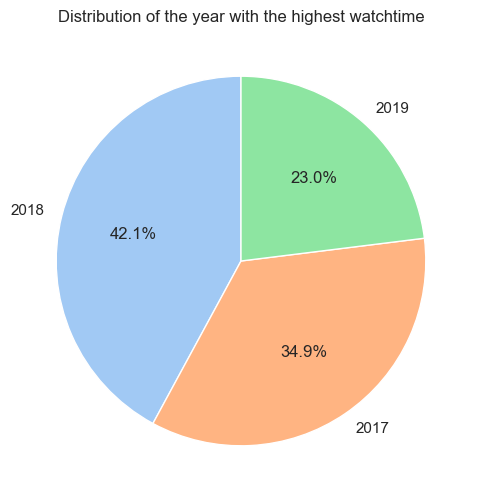

In [ ]:
# Extract the year for each click from the 'datetime' column 
# into the 'year' column in the df DataFrame
df['year'] = pd.to_datetime(df['datetime']).dt.year

# Group by user_id, year, and sum the durations
watchtime_by_year = df.groupby(['user_id', 'year'])['duration'].sum().reset_index(name='total_watchtime')

# Find the year with the maximum total watchtime for each user
# from the three years recorded in the dataset
idx = watchtime_by_year.groupby('user_id')['total_watchtime'].idxmax()

# Get the corresponding row with the most watchtime year for each user
most_watchtime_year = watchtime_by_year.loc[idx]

# Merge the year with the most duration with the users DataFrame
users = pd.merge(users, most_watchtime_year[['user_id', 'year']], on='user_id', how='left').rename(columns={'year': 'most_watchtime_year'})

# Convert the most_watchtime_year column to string in order
# to compute it as a categorical feature
users['most_watchtime_year'] = users['most_watchtime_year'].apply(lambda x: str(x))

# Plot the Distribution of the year with the highest watchtime
plt.figure(figsize=(6, 6))
plt.pie(users['most_watchtime_year'].value_counts(), labels=users['most_watchtime_year'].value_counts().index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("pastel"))
plt.title('Distribution of the year with the highest watchtime')
plt.show()

### (6) Watching Duration Type 

This feature takes into consideration the users' Total Watch Time (duration) for all of the recorded clicks
and classifies them into 4 categories:
- Zero Duration - we added this class because the dataset has a lot of users with duration equal to 0.0 seconds;
- Amateur - users with the total watch duration higher than 0.0 and lower/equal to 50.000 seconds;
- Active - users with the total watch duration higher than 50.000 and lower/equal to 1 milion seconds;
- Enthusiast - users with the total watch duration higher than 1 milion seconds.

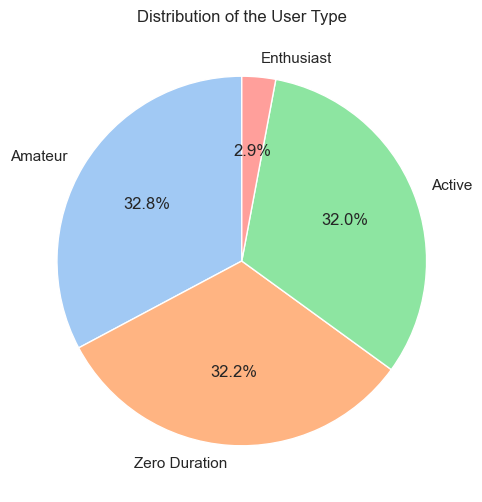

In [ ]:
# Setting the default category in the user_category column to 'Zero Duration'
users['user_category'] = 'Zero Duration'

# Updating class in the users DataFrame to 'Amateur' for users meeting the conditions
users.loc[(users['total_watch_time'] > 0) & (users['total_watch_time'] <= 50000), 'user_category'] = 'Amateur'

# Updating category to 'Active' for users meeting the conditions
users.loc[(users['total_watch_time'] > 50000) & (users['total_watch_time'] <= 1000000), 'user_category'] = 'Active'

# Updating category to 'Enthusiast' for users meeting the conditions
users.loc[(users['total_watch_time'] > 1000000), 'user_category'] = 'Enthusiast'

# Plotting into a piechart the Distribution of the User Type
plt.figure(figsize=(6, 6))
plt.pie(users['user_category'].value_counts(), labels=users['user_category'].value_counts().index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("pastel"))
plt.title('Distribution of the User Type')
plt.show()

### (7) Seasonal Movie Preferences

The season that each user had the most duration (Winter, Spring, Summer, Autumn).

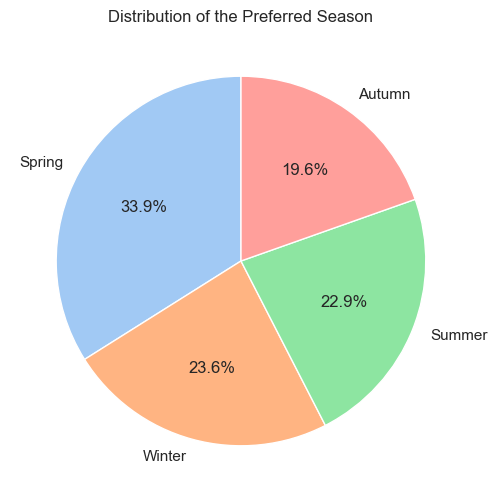

In [ ]:
# Extract the season information from the 'datetime' column in the df DataFrame
# 1: Winter, 2: Spring, 3: Summer, 4: Autumn
df['season'] = (df['datetime'].dt.month % 12 + 3) // 3  # wrapping the months so they continue for the next year after December

# Get total watchtime for each user in each season
season_watchtime = df.groupby(['user_id', 'season'])['duration'].sum().reset_index()

# Determine the preferred season for each user
# by taking the maximum we found
preferred_seasons = season_watchtime.groupby('user_id')[['season', 'duration']].max().reset_index()

# Mapping season numbers to season names
season_mapping = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Autumn'}
preferred_seasons['preferred_season'] = preferred_seasons['season'].map(season_mapping)

# Update the 'users' DataFrame with the preferred season information
users['preferred_season'] = users['user_id'].map(preferred_seasons.set_index('user_id')['preferred_season'])

#Plotting the Distribution of the Preferred Season
plt.figure(figsize=(6, 6))
plt.pie(users['preferred_season'].value_counts(), labels=users['preferred_season'].value_counts().index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("pastel"))
plt.title('Distribution of the Preferred Season')
plt.show()

### (8) Time since the last login (and the last entry in the dataset) 

In [ ]:
# Sort the DataFrame by 'user_id' and 'datetime'
df.sort_values(['user_id', 'datetime'], inplace=True)

# Get the last login time for each user
last_login_time = df.groupby('user_id')['datetime'].last().reset_index()

# Calculate the time difference between the last login for 
# each user and the last entry in the whole dataset
last_entry_time = df['datetime'].max()
last_login_time['days_since_last_entry'] = (last_entry_time - last_login_time['datetime']).dt.days

# Update the 'users' DataFrame with the time since the last entry
users = pd.merge(users, last_login_time[['user_id', 'days_since_last_entry']], on='user_id', how='left')

last_login_time

,user_id,datetime,days_since_last_entry
0,00004e2862,2017-12-05 20:39:15,572
1,000052a0a0,2017-06-26 18:25:42,734
2,000090e7c8,2018-03-09 20:01:40,478
3,000118a755,2018-06-15 03:01:15,380
4,000296842d,2018-12-31 20:16:23,181
...,...,...,...
161913,fffd9bf758,2017-06-21 18:06:32,739
161914,fffe7b777b,2017-08-19 17:03:18,680
161915,fffeac83be,2017-09-20 21:18:18,648
161916,ffff2c5f9e,2017-07-23 15:02:43,707


### (9) Favorite watch day of the week

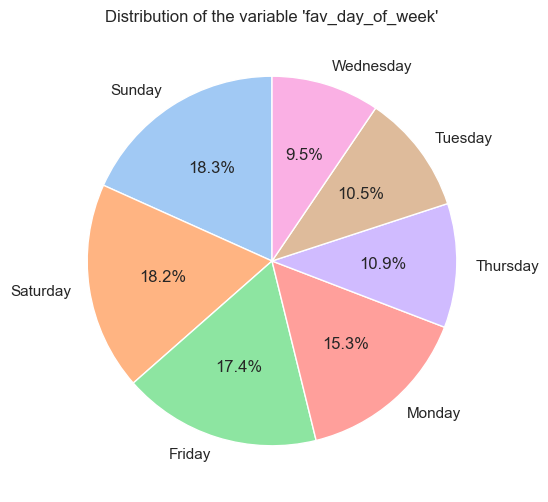

In [ ]:
# Adding a new column 'day_of_week' to the DataFrame with the 
# day of the week for each click, using data from the 'datetime' column
df['day_of_week'] = df['datetime'].dt.day_name()

# We calculate the total clicks for each users grouping the data by day of the week and turn 
# the entry of the users dataset into a dictionary

day_of_week_counts = df.pivot_table(index='user_id', columns='day_of_week', aggfunc='size', fill_value=0)

# Merging 'day_of_week_counts' with the users dataset
users = users.merge(day_of_week_counts, left_on='user_id', right_index=True, how='left')

# Creating the dict only for the days of the week variables
users['clicks_by_day'] = users[users.columns[-7:]].apply(lambda row: row.to_dict(), axis=1)

# Now we can remove the varibles for the single days of the week
cols_to_drop = ['Friday', 'Monday','Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']
users.drop(columns = cols_to_drop,  inplace=True)

# And now we create a features that will have as entry the day of the week with the most clicks
users['fav_day_of_week'] = users['clicks_by_day'].apply(lambda x: max(x, key=x.get) if x else np.nan)

# drop the column 'clicks_by_day'
users.drop(columns = ['clicks_by_day'], inplace=True)

# Plotting
plt.figure(figsize=(6, 6))
plt.pie(users['fav_day_of_week'].value_counts(), labels=users['fav_day_of_week'].value_counts().index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("pastel"))
plt.title('Distribution of the variable \'fav_day_of_week\'')
plt.show()

### (10) Longest click duration

In [ ]:
# Grouping by user_id taking the max value of the duration feature
max_duration_per_user = df.groupby('user_id')['duration'].max().reset_index()

max_duration_per_user.rename(columns={'duration': 'max_duration_click'}, inplace=True)

# merging the dataframe
users = pd.merge(users, max_duration_per_user, on='user_id', how='left')
print(users['max_duration_click'].max())
print(users['max_duration_click'].mean())
print(users['max_duration_click'].std())

18237253.0
105465.00857224027
299411.33218472113


In [ ]:
#Rounding the 'duration' and 'averagetime' column values to 3 decimals
users['duration'] = users['duration'].round(3)
users['averagetime'] = users['averagetime'].round(3)

In [ ]:
#Saving the users dataframe to use in the next task
users.to_csv('users.csv', index=False)

### Users DataFrame with all 15 features

In [ ]:
# Final Users df with all 15 features
users

,user_id,fav_genre,duration,preferred_time_of_day,old_or_new,averagetime,total_watch_time,total_movies_watched,total_genres_watched,average_monthly_movies_watched,most_watchtime_year,user_category,preferred_season,days_since_last_entry,fav_day_of_week,max_duration_click
0,00004e2862,Drama,0.000,night,old,0.000,0.0,1,3,0.033,2017,Zero Duration,Winter,572,Tuesday,0.0
1,000052a0a0,Action,2698.889,afternoon,new,2698.889,48580.0,11,14,0.183,2017,Amateur,Summer,734,Tuesday,7857.0
2,000090e7c8,Sci-Fi,0.000,night,new,0.000,0.0,1,3,0.033,2018,Zero Duration,Spring,478,Friday,0.0
3,000118a755,Horror,0.000,night,new,0.000,0.0,2,1,0.067,2018,Zero Duration,Summer,380,Friday,0.0
4,000296842d,Mystery,15461.600,night,new,14250.600,77308.0,1,4,0.033,2018,Active,Winter,181,Monday,62860.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161913,fffd9bf758,Crime,8495.000,afternoon,new,8495.000,8495.0,1,3,0.033,2017,Amateur,Summer,739,Wednesday,8495.0
161914,fffe7b777b,Sci-Fi,1785.000,afternoon,new,1785.000,1785.0,1,3,0.033,2017,Amateur,Summer,680,Saturday,1785.0
161915,fffeac83be,Drama,40606.273,night,new,9390.091,446669.0,10,9,0.167,2017,Active,Autumn,648,Wednesday,173436.0
161916,ffff2c5f9e,Comedy,0.000,afternoon,new,0.000,0.0,2,5,0.067,2017,Zero Duration,Summer,707,Sunday,0.0


In [ ]:
# Final clicks df 
df

,user_id,movie_id,datetime,click_count,duration,title,genres,release_date,genre_list,hour,time_of_day,release_year,release_category,adjusted_duration,year,season,day_of_week
0,00004e2862,9bfee795ff,2017-12-05 20:39:15,1,0.0,Hannibal,"Crime, Drama, Thriller",2001-02-09,"[Crime, Drama, Thriller]",20,night,2001.0,old,0.0,2017,1,Tuesday
11,000052a0a0,7314699c23,2017-05-23 18:41:44,1,2957.0,Frailty,"Crime, Drama, Thriller",2002-04-12,"[Crime, Drama, Thriller]",18,afternoon,2002.0,old,2957.0,2017,2,Tuesday
12,000052a0a0,7314699c23,2017-05-23 19:47:31,1,1512.0,Frailty,"Crime, Drama, Thriller",2002-04-12,"[Crime, Drama, Thriller]",19,afternoon,2002.0,old,1512.0,2017,2,Tuesday
13,000052a0a0,7314699c23,2017-05-23 21:37:40,1,1198.0,Frailty,"Crime, Drama, Thriller",2002-04-12,"[Crime, Drama, Thriller]",21,night,2002.0,old,1198.0,2017,2,Tuesday
9,000052a0a0,6275614f9a,2017-05-24 07:29:07,1,0.0,Resident Evil,"Action, Horror, Sci-Fi",2002-03-15,"[Action, Horror, Sci-Fi]",7,morning,2002.0,old,0.0,2017,2,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
645216,fffeac83be,338abadc17,2017-09-18 21:03:08,1,173436.0,Fight Club,Drama,1999-10-15,[Drama],21,night,1999.0,old,10611.0,2017,4,Monday
645217,fffeac83be,5a650007e7,2017-09-20 21:18:18,1,129.0,To the Bone,Drama,2017-07-14,[Drama],21,night,2017.0,new,129.0,2017,4,Wednesday
645228,ffff2c5f9e,9ab62a3f2c,2017-07-23 14:45:12,1,0.0,Forks Over Knives,Documentary,2013-10-16,[Documentary],14,afternoon,2013.0,new,0.0,2017,3,Sunday
645227,ffff2c5f9e,6467fee6b6,2017-07-23 15:02:43,1,0.0,Hot Fuzz,"Action, Comedy, Mystery, Thriller",2007-04-20,"[Action, Comedy, Mystery, Thriller]",15,afternoon,2007.0,old,0.0,2017,3,Sunday


# Part 2.2
## Normalising and Dimensionality reduction of the data

In [ ]:
users = pd.read_csv('C:/Users/utente/Desktop/DATA SCIENCE/ADM/HW4/PT2/users.csv')

Dimensionality reduction comes into play when we have to deal with high-dimentional data, which can cause issues like time 
and space complexity, redundance of features, over-fitting and noise problems... 

There are plenty of methods to reduce the dimentionality of datasets; the one we chose is **Principal Component Analysis**.
This method applies linear approximation to find out the components that contribute most to the variance in the dataset.

We chose that because it really gives a good summary of the initial high-dimentional data. One limitation is that our dataset has a significant number of categorical variables, and PCA performs with numerical variables only. What we did to fix this aspect was to encode the categorical variables to turn them in numerical data.

### Normalising
PCA is sensitive to the scale of the variables. If variables are measured in different units or have different ranges, those with larger scales can dominate the principal components. 

So normalising the variables ensures that all variables contribute equally to the principal components also making them more meaningful.

In [ ]:
# since NaN values are present in the dataset, we have to drop them in order to be able to perform PCA
users.fillna(users.mean(), inplace = True)

# Let's specify which are the categorical and which the numerical columns
cat_cols = ['fav_genre', 'preferred_time_of_day', 'old_or_new', 'most_watchtime_year', 'user_category', 'preferred_season', 'fav_day_of_week']
num_cols = ['duration', 'averagetime', 'total_watch_time', 'total_movies_watched','total_genres_watched', 'average_monthly_movies_watched', 'days_since_last_entry', 'max_duration_click']
users_processed = users.copy()
numeric_data = users_processed[num_cols]

# PCA is sensitive to the scale of the variables. If variables are measured in different units or have different ranges,
# those with larger scales can dominate the principal components.
# So normalising the variables ensures that all variables contribute equally to the principal components,
# also making them more meaningful
scaler = StandardScaler()
numeric_data_standardized = scaler.fit_transform(numeric_data)

# Encoding of the categorical variables.
# It's possible to perform PCA when we have also categorical variables thanks to a certain type of encoding
# (OneHotEncoding), which output is a binary matrix where each row represents an observation, and each column
# represents a category. The values are 0 or 1, indicating the absence or presence of the corresponding category 
# for each observation. For this reason now we can merge the two different types of features in one single analysis
encoder = OneHotEncoder(sparse = False)
categorical_data_encoded = encoder.fit_transform(users_processed[cat_cols])

# Concatenation of the standardized numerical variables and the encoded categorical variables
X = pd.concat([pd.DataFrame(numeric_data_standardized, columns=num_cols), pd.DataFrame(categorical_data_encoded, columns=encoder.get_feature_names_out(cat_cols))], axis = 1)

# Perform PCA in the concatenated dataframe. Let's try first with three components
pca = PCA(n_components = 3)
principal_components = pca.fit_transform(X)

# Creating a new dataframe which will have as columns the values for the principal components
pc_df = pd.DataFrame(data = principal_components, columns = ['PC1', 'PC2', 'PC3'])

# Concatenate with the 'user_id' column and setting this as main index
final_df = pd.concat([users_processed[['user_id']], pc_df], axis = 1)
final_df.set_index('user_id', inplace = True)

print('\n\n',final_df.head(),'\n\n')


C:\Users\utente\AppData\Local\Temp\ipykernel_12488\3435591702.py:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  users.fillna(users.mean(), inplace = True)
C:\Users\utente\anaconda32\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(




                  PC1       PC2       PC3
user_id                                 
00004e2862 -1.182316  0.366856 -0.898130
000052a0a0  1.485381 -2.906569 -1.409010
000090e7c8 -1.221992  0.371344 -0.071603
000118a755 -1.206514  0.332502  0.220715
000296842d -0.354382  0.641752  0.968579 




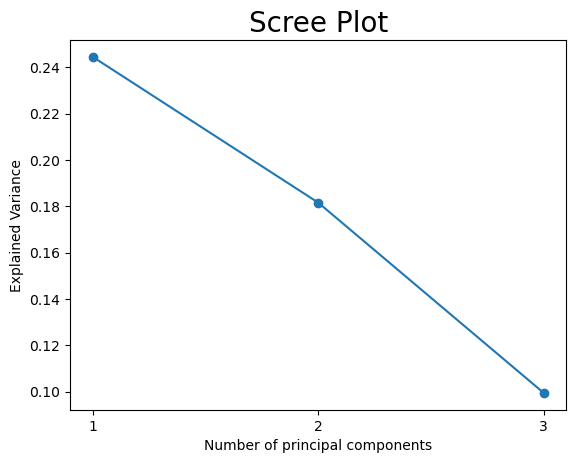



Cumulative explained variance ratio: 
 [0.24447114 0.42600601 0.52539477]


Explained variance ratio for each component: 
 [0.24447114 0.18153487 0.09938877] 




In [ ]:
components = range(1,4)
plt.plot(pca.explained_variance_ratio_, marker = 'o')
plt.xlabel('Number of principal components')
plt.ylabel('Explained Variance')
plt.title('Scree Plot', fontsize = 20)
plt.xticks([comp - 1 for comp in components], labels=components)
plt.show()

explained_variance_ratio_cumulative = np.cumsum(pca.explained_variance_ratio_)
print('\n\nCumulative explained variance ratio: \n', explained_variance_ratio_cumulative)
print('\n\nExplained variance ratio for each component: \n', pca.explained_variance_ratio_, '\n\n')


The plot and the array show us the percentage of variance that each component explains. This means that if we only
consider PC1, we will have the 24.4% of "total data" explained by the component(s). But since we consider more than 
one component, this fractions of explained variance will be cumulated, until we're satisfied with the portion
of data we have as summary, while every value of the second array is the single part of variance. 

We can see that with 3 components the explained variance is only 52.5%, so let's try a PCA with 5 of them.

In [ ]:
# Perform PCA with five components
pca_5 = PCA(n_components = 5)
principal_components_5 = pca_5.fit_transform(X)

# Creating a new dataframe which will have as columns the values for the principal components
pc_df_5 = pd.DataFrame(data = principal_components_5, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])

# Concatenate with the 'user_id' column and setting this as main index
reduct_df = pd.concat([users_processed[['user_id']], pc_df_5], axis = 1)
reduct_df.set_index('user_id', inplace = True)

print('\n\n',reduct_df.head(),'\n\n')



                  PC1       PC2       PC3       PC4       PC5
user_id                                                     
00004e2862 -1.182316  0.366856 -0.898132  0.500422 -0.957242
000052a0a0  1.485381 -2.906569 -1.409011  0.168430  1.145873
000090e7c8 -1.221992  0.371344 -0.071603  0.487427 -0.767927
000118a755 -1.206514  0.332502  0.220714  0.505552 -0.793700
000296842d -0.354382  0.641752  0.968579 -1.142669 -0.755787 




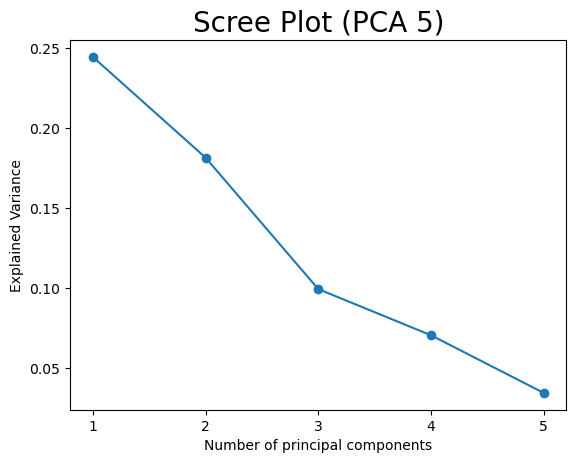



Cumulative explained variance ratio: 
 [0.24447114 0.42600601 0.52539477 0.59592426 0.63042218]


Explained variance ratio for each component: 
 [0.24447114 0.18153487 0.09938877 0.07052949 0.03449792] 




In [ ]:
components_5 = range(1,6)
plt.plot(pca_5.explained_variance_ratio_, marker = 'o')
plt.xlabel('Number of principal components')
plt.ylabel('Explained Variance')
plt.title('Scree Plot (PCA 5)', fontsize = 20)
plt.xticks([comp - 1 for comp in components_5], labels = components_5)
plt.show()

explained_variance_ratio_cumulative_5 = np.cumsum(pca_5.explained_variance_ratio_)
print('\n\nCumulative explained variance ratio: \n', explained_variance_ratio_cumulative_5)
print('\n\nExplained variance ratio for each component: \n', pca_5.explained_variance_ratio_, '\n\n')

Now we can see that the cumulative variance explains the 63% of our data, an amount we can consider acceptable.

Actually the best way to establish which number of components is ideal is the so-called "elbow method", it is saying to stop at the component that in the scree plot has the tightest angle (which means that from the next component on the loss of variance is minimum). Anyway for our purposes 52% of the data was reductive, so we decided to add two more to let the data to be clearer.

# 2.3 Clustering

## 1. K-means clustering algorithm

In [ ]:
cluster_data = reduct_df.values 

## 2. Find an optimal number of clusters

1. Elbow Method

The elbow method is a common technique used to identify the point at which increasing the number of clusters does not significantly decrease the sum of squared errors (SSE) within each cluster. With the elbow method, we plot the number of clusters (K) against the SSE and look for the "elbow" point where the rate of decrease in SSE slows down.

In [ ]:
# Specify the range of K values
k_range = range(3, 11)
sse_values_1 = elbow_method(cluster_data, k_range)

 12%|█▎        | 1/8 [00:01<00:13,  1.86s/it]

K=3, SSE=873564.1325440034


 25%|██▌       | 2/8 [00:04<00:15,  2.58s/it]

K=4, SSE=671873.420185477


 38%|███▊      | 3/8 [00:07<00:12,  2.51s/it]

K=5, SSE=568258.5401262476


 50%|█████     | 4/8 [00:09<00:10,  2.54s/it]

K=6, SSE=535713.168646849


 62%|██████▎   | 5/8 [00:15<00:11,  3.67s/it]

K=7, SSE=487501.03023457696


 75%|███████▌  | 6/8 [00:23<00:09,  4.96s/it]

K=8, SSE=453852.29636987066


 88%|████████▊ | 7/8 [00:34<00:07,  7.20s/it]

K=9, SSE=431888.4274330038


100%|██████████| 8/8 [00:44<00:00,  5.52s/it]

K=10, SSE=370351.73251509963


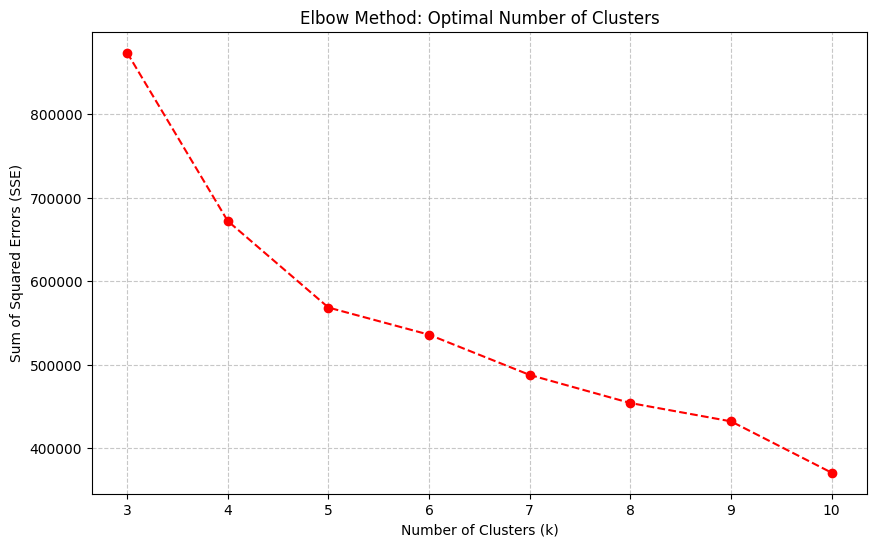

In [ ]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(range(3, 11), sse_values_1, 'ro--') 
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method: Optimal Number of Clusters')
plt.grid(True, linestyle='--', alpha=0.7) 
plt.show()

2. Silhouette Scores Method

It measures how well-defined the clusters are in a given set of data. The silhouette score ranges from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.

In [ ]:
# Specify the range of K values
k_range = range(3, 11)
silhouette_scores_1 = silhouette_scores_method(cluster_data, k_range)

  0%|          | 0/8 [00:00<?, ?it/s]

Model is done


 12%|█▎        | 1/8 [12:58<1:30:49, 778.44s/it]

silhouette_score is done
K=3, Silhouette Score=0.4010099041728049
Model is done


 25%|██▌       | 2/8 [24:42<1:13:28, 734.76s/it]

silhouette_score is done
K=4, Silhouette Score=0.28624659600561997
Model is done


 38%|███▊      | 3/8 [36:17<59:43, 716.65s/it]  

silhouette_score is done
K=5, Silhouette Score=0.3007615337581568
Model is done


 50%|█████     | 4/8 [47:46<47:01, 705.47s/it]

silhouette_score is done
K=6, Silhouette Score=0.3034884082046855
Model is done


 62%|██████▎   | 5/8 [58:41<34:22, 687.57s/it]

silhouette_score is done
K=7, Silhouette Score=0.2101583335777251
Model is done


 75%|███████▌  | 6/8 [1:08:15<21:37, 648.66s/it]

silhouette_score is done
K=8, Silhouette Score=0.2520924499749374
Model is done


 88%|████████▊ | 7/8 [1:15:51<09:45, 585.77s/it]

silhouette_score is done
K=9, Silhouette Score=0.23321682239357022
Model is done


100%|██████████| 8/8 [1:20:37<00:00, 604.70s/it]

silhouette_score is done
K=10, Silhouette Score=0.24138660630175596


In [ ]:
silhouette_scores_1

[0.4009381419617773,
 0.2862440409029154,
 0.3007615337581568,
 0.24416699830103333,
 0.2545886336229855,
 0.264269364916725,
 0.2326767482485982,
 0.2649005920193317]

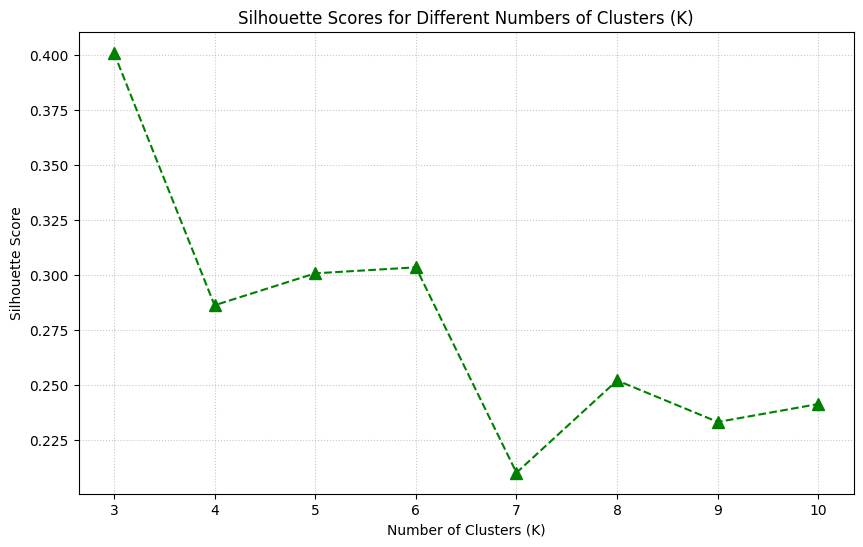

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(3, 11), silhouette_scores_1, 'g^--', markersize=8, label='Silhouette Scores') 
plt.title('Silhouette Scores for Different Numbers of Clusters (K)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.grid(True, linestyle=':', alpha=0.7) 
plt.show()

It's worth noting that the selection of K is somewhat subjective, especially when analyzing the Elbow Method.The rate of decrease appears to slow down after K=5. The point at which this slowdown occurs is often considered the elbow point, and it suggests that K=5 might be a reasonable choice for the number of clusters in your k-means algorithm.

The highest silhouette score is achieved when K=3, indicating that the data points are well-matched to their clusters and poorly matched to neighboring clusters.

Considering the results of the two methods, it would be reasonable to choose K=3 as the number of clusters for the k-means algorithm.

## 4. K-means++ clustering algorithm

1. Elbow Method

In [ ]:
# Initialize an empty list to store SSE
sse_values_plus = []

# Iterate over different Ks
for num_clusters in range(3, 11):
    try:
        # Perform K-means clustering using K Means ++ initialization
        _, _, sse = k_means_plusplus(cluster_data, num_clusters)
        
        # Append sse
        sse_values_plus.append(sse)
        
        print(f"K={num_clusters}, SSE={sse}")
    except Exception as e:
        print(f"An error occurred at K={num_clusters}: {e}")

K=3, SSE=803644.0708122276
K=4, SSE=671873.473683509
K=5, SSE=568258.541071188
K=6, SSE=505584.18543539447
K=7, SSE=481271.45916663617
K=8, SSE=456398.4561473893
K=9, SSE=397197.56700212555
K=10, SSE=372401.30748263706


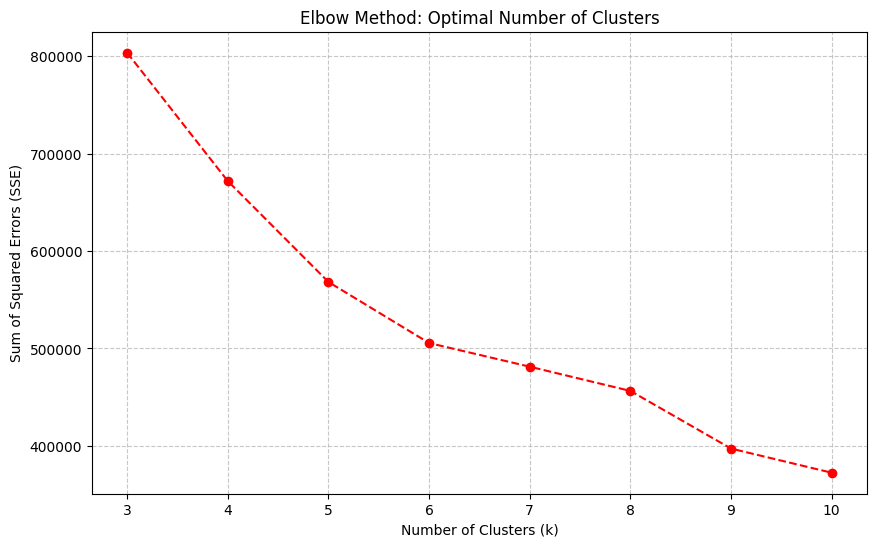

In [ ]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(range(3, 11), sse_values_plus, 'ro--') 
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method: Optimal Number of Clusters')
plt.grid(True, linestyle='--', alpha=0.7) 
plt.show()

2. Silhouette Scores Method

In [ ]:
# Initialize an empty list to store Silhouette Scores
silhouette_scoress = []

# Iterate over different values of K
for num_clusters in tqdm(range(3, 11)):
    # KMeans++ initialization
    _, cluster_labels, _ = k_means_plusplus(cluster_data, num_clusters)    
    print('Model is done')
    
    # Calculate Silhouette Score
    score = silhouette_score(cluster_data, cluster_labels)
    print('silhouette_score is done')
    
    silhouette_scoress.append(score)
    
    print(f"K={num_clusters}, Silhouette Score={score}")

  0%|          | 0/8 [00:00<?, ?it/s]

Model is done


 12%|█▎        | 1/8 [11:15<1:18:49, 675.65s/it]

silhouette_score is done
K=3, Silhouette Score=0.2551505982032008
Model is done


 25%|██▌       | 2/8 [24:03<1:13:00, 730.07s/it]

silhouette_score is done
K=4, Silhouette Score=0.3620608884774299
Model is done


 38%|███▊      | 3/8 [35:30<59:10, 710.09s/it]  

silhouette_score is done
K=5, Silhouette Score=0.3355743465558704
Model is done


 50%|█████     | 4/8 [43:20<41:02, 615.50s/it]

silhouette_score is done
K=6, Silhouette Score=0.24416867522391733
Model is done


 62%|██████▎   | 5/8 [49:43<26:34, 531.58s/it]

silhouette_score is done
K=7, Silhouette Score=0.3123113662217812
Model is done


 75%|███████▌  | 6/8 [55:52<15:52, 476.47s/it]

silhouette_score is done
K=8, Silhouette Score=0.28020926814861835
Model is done


 88%|████████▊ | 7/8 [1:01:59<07:20, 440.44s/it]

silhouette_score is done
K=9, Silhouette Score=0.2464498378151881
Model is done


100%|██████████| 8/8 [1:07:56<00:00, 509.60s/it]

silhouette_score is done
K=10, Silhouette Score=0.2688701461853762


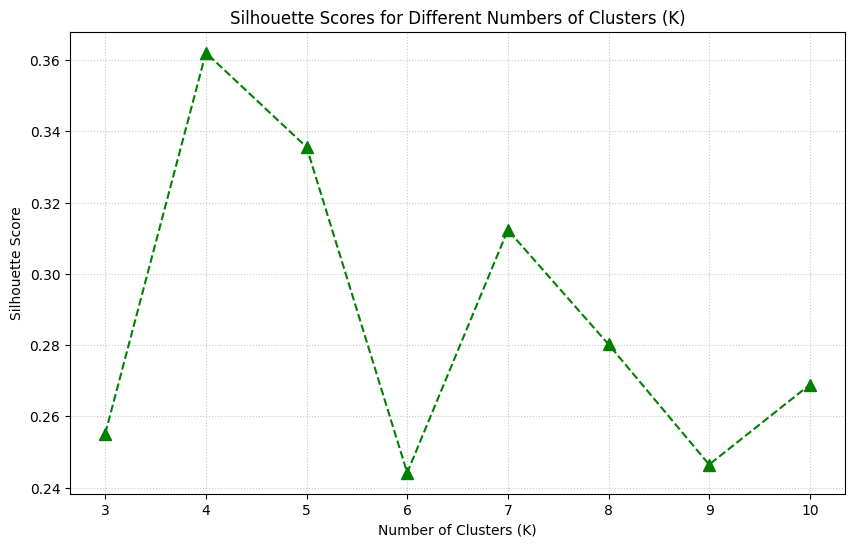

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(3, 11), silhouette_scoress, 'g^--', markersize=8, label='Silhouette Scores') 
plt.title('Silhouette Scores for Different Numbers of Clusters (K)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.grid(True, linestyle=':', alpha=0.7) 
plt.show()

The SSE values with k-means++ initialization appear to be lower than those with k clustering. This suggests that k-means++ initialization has contributed to better convergence and potentially better-defined clusters. 

The lower SSE values with k-means++ imply that the clusters formed may have tighter and more well-defined structures.


## 2.3.5. Density-Based Spatial Clustering of Applications with Noise

In [ ]:
# Assuming reduct_df is your DataFrame
cluster_data = reduct_df.values

# Apply DBSCAN clustering algorithm
# eps and min_samples are hyperparameters that can be tuned
# For this example, we'll use default values
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(cluster_data)

# Number of clusters found (excluding noise points)
n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)

# Display the number of clusters and first 10 cluster assignments
print(f"Number of Clusters: {n_clusters}")
print(f"Cluster Assignments (First 10): {clusters[:10]}")

# Calculate Silhouette Score
silhouette_score_dbscan = silhouette_score(cluster_data, clusters)
print(f"Silhouette Score: {silhouette_score_dbscan}")


Number of Clusters: 119
Cluster Assignments (First 10): [0 0 0 0 0 0 0 0 0 0]
Silhouette Score: 0.09001340898020023


 A high number of clusters may suggest that the algorithm is sensitive to noise or small variations in the data. The silhouette score is relatively low, indicating that the clusters may have some overlap or are not well-separated. 

# 5. Algorithmic Question (AQ)

### a)Fortunately, you have a computer app designed by a brilliant student. Federico wants you to show him the code which this app is based on because he wants to do paid counseling for other desperate students: in a recursive fashion, the helped helps the helpable.

In [ ]:
# Get the initial personal score and list of marks
s = int(input("Initial personal score: "))
list_p = list(map(int, input("Marks: ").split()))

# Define a recursive function to calculate the highest reachable number
def f(s, list_p, index=1):
    # Base case: If there is only one mark in the list, return it
    if len(list_p) == 1:
        return list_p[0]

    #find the maximum and minimum marks in the list
    max_list_p = max(list_p)
    min_list_p = min(list_p)

    # Adjust the index to handle even-sized lists differently
    if index == 1:
        check=len(list_p)
        if check%2==0:
            index=index+1

    # If the current index is odd, increase the personal score to the maximum mark
    if index % 2 != 0:
        new_s = max_list_p
        x = new_s - s
        list_p.sort(reverse=True)
        new_list_p = [num - x for num in list_p[1:]]#Adjust the list based on the given rule
        return f(new_s, new_list_p, index + 1) # Recursively call the function with the updated personal score and marks

    # If the current index is even, decrease the personal score to the minimum mark
    if index % 2 == 0:
        new_s = min_list_p
        x = s - new_s
        list_p.sort()
        new_list_p = [num + x for num in list_p[1:]] #Adjust the list based on the given rule
        return f(new_s, new_list_p, index + 1) # Recursively call the function with the updated personal score and marks

result = f(s, list_p)
print("The highest reachable number:", result)

Initial personal score: 30
Marks: 13 27 41 59 28 33 39 19 52 48 55 79
The highest reachable number: 205


### b) Federico is getting angry because he claims that your code is slow! Show him formally with a big-O notation that he is as crazy as this university!

For each recursive call, the sorting operation has a time complexity of O(n log n), and the arithmetic operation has a time complexity of O(n).The depth of the recursion is log(n). Therefore, the overall time complexity of the algorithm can be expressed as O(log(n) * (n log n + n)). In big-O notation, the dominant term is the sorting operation, so the time complexity can be simplified to O(log(n) * n log n) which is the worst-case scenario of my algorithm.. 

### c) If, unfortunately, Federico is right in the grip of madness, he will threaten you to optimize the code through a different approach. You should end this theater of the absurd by any means! (And again, formally prove that you improved time complexity)

in the previous algorithm, I used list_p.sort() and list_p.sort(reverse=True) for sorting, which has a time complexity of O(n log n) in the worst case. In the optimized algorithm, I used list_p.remove() instead of list_p.sort(), which has a time complexity of O(n) in the worst case. Removing an element from a list is generally faster than sorting the entire list.For each recursive call, the dominant factor is the removal of elements and the subsequent iteration through the list. The depth of the recursion is log(n), where n is the length of the original list. Therefore, the overall time complexity of my algorithm is approximately O(n log n).By replacing the sorting operations with the removal operation, I have reduced the time complexity of the algorithm. The removal operation has a lower time complexity than sorting, especially when dealing with larger lists.

In [ ]:
# Get the initial personal score and list of marks
s = int(input("Initial personal score: "))
list_p = list(map(int, input("Marks: ").split()))

# Define a recursive function to calculate the highest reachable number
def f(s, list_p, index=1):
     # Base case: If there is only one mark in the list, return it
    if len(list_p) == 1:
        return list_p[0]

    #find the maximum and minimum marks in the list
    max_list_p = max(list_p)
    min_list_p = min(list_p)

    # Adjust the index to handle even-sized lists differently
    if index == 1 and len(list_p)%2==0:
            index+=1

    # If the current index is odd, increase the personal score to the maximum mark        
    if index % 2 != 0:
        new_s = max_list_p
        x = new_s - s
        list_p.remove(new_s)
        new_list_p = [num - x for num in list_p] #Adjust the list based on the given rule

    # If the current index is even, decrease the personal score to the minimum mark
    else:
        new_s = min_list_p
        x = s - new_s
        list_p.remove(new_s)
        new_list_p = [num + x for num in list_p] #Adjust the list based on the given rule
        
    return f(new_s, new_list_p, index + 1)# Recursively call the function with the updated personal score and marks

result = f(s, list_p)
print("The highest reachable number:", result)

Initial personal score: 25
Marks: 18 24 21 32 27
The highest reachable number: 44


### d) Ask chatGPT for a third (optimized) implementation and analyze again its time complexity. Be careful (and crafty) in defining the prompt, and challenge the machine in this coding question!

I asked ChatGPT for final optimization, and it suggested that I eliminate the .remove() function to minimize the time complexity of my code. Instead, in the list comprehension, I need to provide an if statement to exclude the element that we want to delete. Therefore, as can be seen, by doing so, the time complexity of my algorithm will be O(n log n). The dominant factor in each recursive call is the list comprehension, which has a time complexity of O(n). The depth of the recursion is log(n), where n is the length of the original list. Therefore, the overall time complexity of my algorithm is approximately O(n log n). The dominant factor is the list comprehension within the recursion, and the rest of the operations contribute to the overall complexity.

In [ ]:
# Get the initial personal score and list of marks
s = int(input("Initial personal score: ")) 
list_p = list(map(int, input("Marks: ").split()))

# Define a recursive function to calculate the highest reachable number
def f(s, list_p, index=1):
    # Base case: If there is only one mark in the list, return it
    if len(list_p) == 1:
        return list_p[0]

    #find the maximum and minimum marks in the list
    max_index = list_p.index(max(list_p))
    min_index = list_p.index(min(list_p))

    
    # Adjust the index to handle even-sized lists differently
    if index == 1 and len(list_p) % 2 == 0:
        index += 1

    # If the current index is odd, increase the personal score to the maximum mark
    if index % 2 != 0:
        new_s = max(list_p)
        x = new_s - s
        #Adjust the list based on the given rule
        new_list_p = [num - x for i, num in enumerate(list_p) if i != max_index]
    
    # If the current index is even, decrease the personal score to the minimum mark
    else:
        new_s = min(list_p)
        x = s - new_s
        #Adjust the list based on the given rule
        new_list_p = [num + x for i, num in enumerate(list_p) if i != min_index]

    # Recursively call the function with the updated personal score and marks
    return f(new_s, new_list_p, index + 1)

result = f(s, list_p)
print("The highest reachable number:", result)

Initial personal score: 30
Marks: 13 27 41 59 28 33 39 19 52 48 55 79
The highest reachable number: 205
